In [1]:
!pip3 install catboost
!pip install fast_ml

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import pandas as pd
import numpy as np 

from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from sklearn.model_selection import train_test_split
from catboost import CatBoostRegressor
import catboost as cbr
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import StackingRegressor
from xgboost import XGBRegressor

# for checking performance
from sklearn import metrics

from sklearn.metrics import r2_score, mean_absolute_error
from sklearn.metrics import mean_squared_error

from fast_ml.feature_engineering import FeatureEngineering_Numerical, FeatureEngineering_Categorical, FeatureEngineering_DateTime
from fast_ml.outlier_treatment import OutlierTreatment
from fast_ml.missing_data_analysis import MissingDataAnalysis
from fast_ml.model_evaluation import threshold_evaluation
from fast_ml.feature_selection import get_constant_features
from fast_ml.model_development import train_valid_test_split
from fast_ml.model_evaluation import threshold_evaluation
from fast_ml import eda

In [3]:
dftrain = pd.read_csv('/content/job_hack_train.csv')
dftest = pd.read_csv('/content/job_hack_test.csv')

In [4]:
dftrain.head()

,row_id,datetime,energy
0,1,2008-03-01 00:00:00,1259.985563
1,2,2008-03-01 01:00:00,1095.541500
2,3,2008-03-01 02:00:00,1056.247500
3,4,2008-03-01 03:00:00,1034.742000
4,5,2008-03-01 04:00:00,1026.334500


In [5]:
dftest.head()

,row_id,datetime
0,94993,2019-01-01 00:00:00
1,94994,2019-01-01 01:00:00
2,94995,2019-01-01 02:00:00
3,94996,2019-01-01 03:00:00
4,94997,2019-01-01 04:00:00


## Exploratory Data Analysis

In [6]:
dftrain.shape,dftest.shape

((94992, 3), (26304, 2))

In [7]:
dftrain.info(),
print('\n===================\n')
dftest.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 94992 entries, 0 to 94991
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   row_id    94992 non-null  int64  
 1   datetime  94992 non-null  object 
 2   energy    93092 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 2.2+ MB


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26304 entries, 0 to 26303
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   row_id    26304 non-null  int64 
 1   datetime  26304 non-null  object
dtypes: int64(1), object(1)
memory usage: 411.1+ KB


In [8]:
print(dftrain.isna().sum()),
print('==================')
dftest.isna().sum()

row_id         0
datetime       0
energy      1900
dtype: int64


row_id      0
datetime    0
dtype: int64

## Data Cleaning

In [9]:
dftrain = dftrain.fillna(dftrain.interpolate())
dftrain.shape

(94992, 3)

## Feature Engineering


Covert the datetime columns of the dataframes to datetime objects


In [10]:
dftrain.datetime = pd.to_datetime(dftrain.datetime)
dftest.datetime = pd.to_datetime(dftest.datetime)

Make copies of the dataframes


In [11]:
df_train = dftrain.copy()
df_test = dftest.copy()

Temporarily drop row_id column from copied datafrmes

In [12]:
df_train = df_train.drop('row_id', axis = 1)
df_test = df_test.drop('row_id', axis = 1)

Set datetime column as index

In [13]:
df_train = df_train.set_index('datetime')
df_test = df_test.set_index('datetime')

Energy evolution

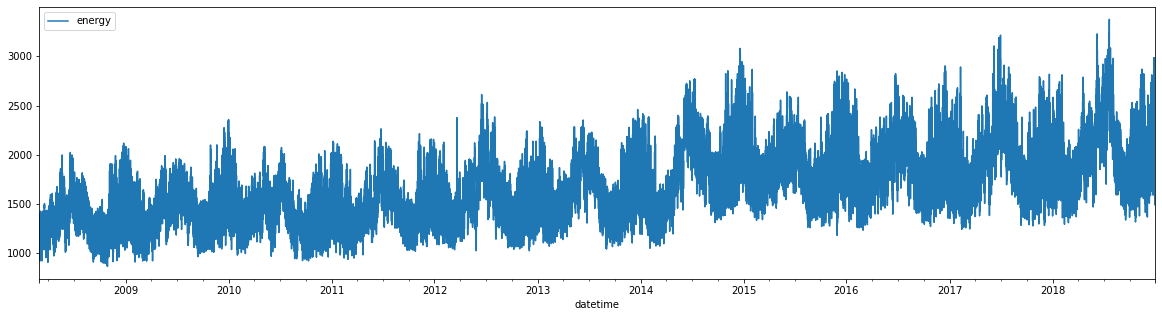

In [14]:
df_train.plot(figsize=(20,5))

Autotorelation

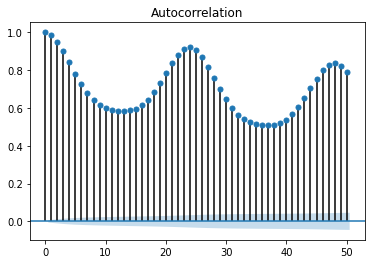

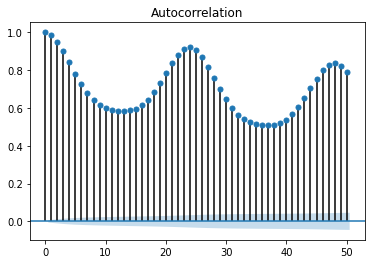

In [15]:
plot_acf(df_train)


Partial autotorelation

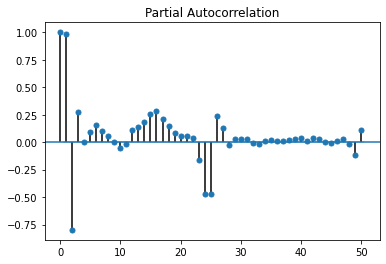

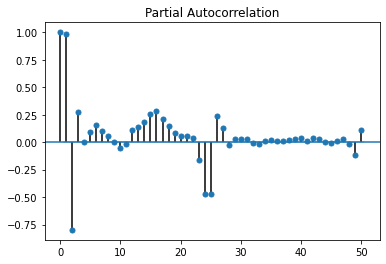

In [16]:
plot_pacf(df_train)


In [17]:
df_test = dftest.copy()
df_train = dftrain.copy()

Create more features from datetime

In [18]:
fe = FeatureEngineering_DateTime()

fe.fit(df_train, datetime_variables=['datetime'], prefix = 'data ')
df_train = fe.transform(df_train)

fe.fit(df_test, datetime_variables=['datetime'], prefix = 'data ')
df_test = fe.transform(df_test)


Create columns in the **df_train** data

In [19]:
df_train["month_end"] = df_train["data is_month_end"].astype(int)
df_train["month_start"] = df_train["data is_month_start"].astype(int)
df_train["quarter_end"] = df_train["data is_quarter_end"].astype(int)
df_train["quarter_start"] = df_train["data is_quarter_start"].astype(int)
df_train["year_start"] = df_train["data is_year_start"].astype(int)
df_train["year_end"] = df_train["data is_year_end"].astype(int)

Create columns in the **df_test** data


In [20]:
df_test["month_end"] = df_test["data is_month_end"].astype(int)
df_test["month_start"] = df_test["data is_month_start"].astype(int)
df_test["quarter_end"] = df_test["data is_quarter_end"].astype(int)
df_test["quarter_start"] = df_test["data is_quarter_start"].astype(int)
df_test["year_start"] = df_test["data is_year_start"].astype(int)
df_test["year_end"] = df_test["data is_year_end"].astype(int)

Drop the unneeded columns from the dataframes


In [21]:
df_train = df_train[:len(df_train)].drop(['datetime','data day_part','data time'],axis=1)
df_test = df_test[:len(df_test)].drop(['datetime','data day_part','data time'],axis=1)

In [22]:
df_train.head()

,row_id,energy,data year,data quarter,data month,data day,data day_of_week,data day_of_year,data weekofyear,data is_month_end,...,data hour,data minute,data second,data is_weekend,month_end,month_start,quarter_end,quarter_start,year_start,year_end
0,1,1259.985563,2008,1,3,1,5,61,9,False,...,0,0,0,1,0,1,0,0,0,0
1,2,1095.541500,2008,1,3,1,5,61,9,False,...,1,0,0,1,0,1,0,0,0,0
2,3,1056.247500,2008,1,3,1,5,61,9,False,...,2,0,0,1,0,1,0,0,0,0
3,4,1034.742000,2008,1,3,1,5,61,9,False,...,3,0,0,1,0,1,0,0,0,0
4,5,1026.334500,2008,1,3,1,5,61,9,False,...,4,0,0,1,0,1,0,0,0,0


In [23]:
df_test.head()

,row_id,data year,data quarter,data month,data day,data day_of_week,data day_of_year,data weekofyear,data is_month_end,data is_month_start,...,data hour,data minute,data second,data is_weekend,month_end,month_start,quarter_end,quarter_start,year_start,year_end
0,94993,2019,1,1,1,1,1,1,False,True,...,0,0,0,0,0,1,0,1,1,0
1,94994,2019,1,1,1,1,1,1,False,True,...,1,0,0,0,0,1,0,1,1,0
2,94995,2019,1,1,1,1,1,1,False,True,...,2,0,0,0,0,1,0,1,1,0
3,94996,2019,1,1,1,1,1,1,False,True,...,3,0,0,0,0,1,0,1,1,0
4,94997,2019,1,1,1,1,1,1,False,True,...,4,0,0,0,0,1,0,1,1,0


Reset index to row_id

In [24]:
df_train = df_train.set_index('row_id')
df_test = df_test.set_index('row_id')

## Data Preprocessing
Set the features and label

In [25]:
# features
X = df_train.drop('energy', axis=1)

# label
y = df_train["energy"]

Scale the features

In [45]:
from sklearn.preprocessing import StandardScaler
scaler=StandardScaler()
X_scaled = scaler.fit_transform(X)
test_scaled = scaler.transform(df_test)

Split data into train and test sets


In [27]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=50)
#print(X_train.shape, X_test.shape, y_train.shape, y_test.shape, test_scaled.shape)

## Modeling
CatBoost

In [28]:
training = cbr.Pool(X_train, y_train) 
testing = cbr.Pool(X_test, y_test)

my_model = cbr.CatBoostRegressor(loss_function='RMSE')

grid = {'iterations': [100, 150, 200],
        'learning_rate': [0.03, 0.1],
        'depth': [2, 4, 6, 8],
        'l2_leaf_reg': [0.2, 0.5, 1, 3]}

my_model.grid_search(grid, training)
my_model.fit(X_train, y_train)


Streaming output truncated to the last 5000 lines.
151:	learn: 127.7068468	test: 129.7070247	best: 129.7070247 (151)	total: 1.75s	remaining: 553ms
152:	learn: 127.4940059	test: 129.5077264	best: 129.5077264 (152)	total: 1.76s	remaining: 541ms
153:	learn: 127.3756859	test: 129.4024938	best: 129.4024938 (153)	total: 1.77s	remaining: 529ms
154:	learn: 127.2723901	test: 129.3082281	best: 129.3082281 (154)	total: 1.78s	remaining: 517ms
155:	learn: 127.1278556	test: 129.1774375	best: 129.1774375 (155)	total: 1.79s	remaining: 505ms
156:	learn: 127.0271832	test: 129.0763290	best: 129.0763290 (156)	total: 1.8s	remaining: 493ms
157:	learn: 126.6760168	test: 128.6981751	best: 128.6981751 (157)	total: 1.83s	remaining: 486ms
158:	learn: 126.5193821	test: 128.5533525	best: 128.5533525 (158)	total: 1.84s	remaining: 474ms
159:	learn: 126.4163482	test: 128.4458055	best: 128.4458055 (159)	total: 1.85s	remaining: 462ms
160:	learn: 126.2262156	test: 128.2271819	best: 128.2271819 (160)	total: 1.86s	remaini

In [29]:
#  make prediction with X_test data
pred_model = my_model.predict(X_test)

# Evaluate result from the gradient boosting regression model
print("Accuracy of the Gradient Boosting Regression model is",r2_score(y_test,pred_model))
print("RMSE: ", np.sqrt(mean_squared_error(y_test,pred_model)), '\nMAE: ',mean_absolute_error(y_test, pred_model))


Accuracy of the Gradient Boosting Regression model is 0.9137934638414015
RMSE:  108.69161009853833 
MAE:  82.11854761251392


#### CatBoost Regression Model


In [33]:
cbr = CatBoostRegressor(iterations=10,
                        learning_rate = 1,
                        loss_function = 'RMSE',
                          depth=6,
                        random_state = 0)
cbr.fit(X_train, y_train)

0:	learn: 223.6599342	total: 13.3ms	remaining: 119ms
1:	learn: 194.3110018	total: 25.2ms	remaining: 101ms
2:	learn: 181.6636857	total: 37.3ms	remaining: 87.1ms
3:	learn: 172.9177352	total: 49ms	remaining: 73.6ms
4:	learn: 169.9826968	total: 60.6ms	remaining: 60.6ms
5:	learn: 162.9226413	total: 71.9ms	remaining: 48ms
6:	learn: 157.0316905	total: 84.4ms	remaining: 36.2ms
7:	learn: 153.3123899	total: 96.5ms	remaining: 24.1ms
8:	learn: 150.2008732	total: 108ms	remaining: 12ms
9:	learn: 148.1302226	total: 119ms	remaining: 0us


In [34]:
#  make prediction with X_test data
c_pred = cbr.predict(X_test)

# Evaluate result from the cat boosting regression model
print("Accuracy of the Cat Boosting Regression model is",r2_score(y_test,c_pred))
print("RMSE: ", np.sqrt(mean_squared_error(y_test,c_pred)), '\nMAE: ',mean_absolute_error(y_test, c_pred))


Accuracy of the Cat Boosting Regression model is 0.8368954329602039
RMSE:  149.50612506776378 
MAE:  114.22708338328415


#### Bagging Catboost

In [35]:
cbr = CatBoostRegressor(iterations=10,
                        learning_rate = 1,
                        loss_function = 'RMSE',
                          depth=6,
                        random_state = 0)

bag_cbr = BaggingRegressor(base_estimator = cbr)

bag_cbr.fit(X_train, y_train)

#  make prediction with X_test data
pred_bag_cbr = bag_cbr.predict(X_test)

# Evaluate result from the Bagging CatBoost regression model
print("Accuracy of the Bagging CatBoost Regression model is",r2_score(y_test,pred_bag_cbr))
print("RMSE: ", np.sqrt(mean_squared_error(y_test,pred_bag_cbr)), '\nMAE: ',mean_absolute_error(y_test, pred_bag_cbr))


0:	learn: 221.1942609	total: 11.5ms	remaining: 104ms
1:	learn: 192.5604317	total: 22.2ms	remaining: 88.7ms
2:	learn: 181.4129661	total: 32.8ms	remaining: 76.5ms
3:	learn: 175.6767228	total: 47ms	remaining: 70.4ms
4:	learn: 171.2149078	total: 57.8ms	remaining: 57.8ms
5:	learn: 165.2771249	total: 68.8ms	remaining: 45.9ms
6:	learn: 160.6511657	total: 79.7ms	remaining: 34.2ms
7:	learn: 156.1190793	total: 93.7ms	remaining: 23.4ms
8:	learn: 154.0632311	total: 105ms	remaining: 11.6ms
9:	learn: 150.3313815	total: 116ms	remaining: 0us
0:	learn: 219.1644761	total: 12.7ms	remaining: 115ms
1:	learn: 194.9727042	total: 26.3ms	remaining: 105ms
2:	learn: 179.8120264	total: 38.4ms	remaining: 89.6ms
3:	learn: 174.7253234	total: 48.9ms	remaining: 73.3ms
4:	learn: 168.3957839	total: 64.7ms	remaining: 64.7ms
5:	learn: 162.7079861	total: 76.2ms	remaining: 50.8ms
6:	learn: 157.5571644	total: 87.4ms	remaining: 37.4ms
7:	learn: 152.2722815	total: 99.2ms	remaining: 24.8ms
8:	learn: 148.8129592	total: 110ms	rem

#### XGBoost

In [36]:
# define model
xgb = XGBRegressor(learning_rate = 0.1,
                   max_depth = 100,
                   colsample_bytree = 0.5,
                   n_estimators= 1000)

xgb.fit(X_train, y_train)


[19:50:56] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(colsample_bytree=0.5, max_depth=100, n_estimators=1000)

In [37]:
#  make prediction with X_test data
pred_xgb = xgb.predict(X_test)

# Evaluate result from the XGBooost regression model
print("Accuracy of the XGBooost Regression model is",r2_score(y_test,pred_xgb))
print("RMSE: ", np.sqrt(mean_squared_error(y_test,pred_xgb)), '\nMAE: ',mean_absolute_error(y_test, pred_xgb))


Accuracy of the XGBooost Regression model is 0.9917125398367332
RMSE:  33.70052383555381 
MAE:  23.68612171863726


#### Stacking

In [41]:
# Define the models which we'll include in our ensemble as a list of tuples. 
models = [("Catboostregressor",cbr),("Catboost",my_model),("Bag Cat",bag_cbr)]

# Instead of choosing model weightings, we now declare the meta learner 
meta_learner_reg = CatBoostRegressor()

s_reg = StackingRegressor(estimators=models, final_estimator=meta_learner_reg)

# train the data by fitting in a stacking ensemble model
s_reg.fit(X_train,y_train)


0:	learn: 223.6599342	total: 54.2ms	remaining: 488ms
1:	learn: 194.3110018	total: 72ms	remaining: 288ms
2:	learn: 181.6636857	total: 106ms	remaining: 248ms
3:	learn: 172.9177352	total: 121ms	remaining: 181ms
4:	learn: 169.9826968	total: 136ms	remaining: 136ms
5:	learn: 162.9226413	total: 151ms	remaining: 101ms
6:	learn: 157.0316905	total: 183ms	remaining: 78.6ms
7:	learn: 153.3123899	total: 214ms	remaining: 53.4ms
8:	learn: 150.2008732	total: 237ms	remaining: 26.4ms
9:	learn: 148.1302226	total: 253ms	remaining: 0us
0:	learn: 344.2956536	total: 87.2ms	remaining: 17.3s
1:	learn: 322.2618277	total: 116ms	remaining: 11.5s
2:	learn: 303.1266544	total: 170ms	remaining: 11.2s
3:	learn: 286.2792929	total: 220ms	remaining: 10.8s
4:	learn: 271.4682090	total: 265ms	remaining: 10.3s
5:	learn: 258.0763872	total: 315ms	remaining: 10.2s
6:	learn: 246.3218750	total: 370ms	remaining: 10.2s
7:	learn: 236.4682643	total: 419ms	remaining: 10.1s
8:	learn: 226.9640656	total: 490ms	remaining: 10.4s
9:	learn: 

StackingRegressor(estimators=[('Catboostregressor',
                               <catboost.core.CatBoostRegressor object at 0x7f8916f09290>),
                              ('Catboost',
                               <catboost.core.CatBoostRegressor object at 0x7f8916f331d0>),
                              ('Bag Cat',
                               BaggingRegressor(base_estimator=<catboost.core.CatBoostRegressor object at 0x7f8916f09290>))],
                  final_estimator=<catboost.core.CatBoostRegressor object at 0x7f8916f626d0>)

In [42]:
#  make prediction with X_test data
s_pred = s_reg.predict(X_test)

# Evaluate result from the stacking regression model
print("Accuracy of the stacking regressor model is",r2_score(y_test,s_pred))
print("RMSE: ", np.sqrt(mean_squared_error(y_test,s_pred)), '\nMAE: ',mean_absolute_error(y_test, s_pred))


Accuracy of the stacking regressor model is 0.9249222758558371
RMSE:  101.4335147146369 
MAE:  77.17619860201157


Make prediction with **unseen data**


In [46]:
pred_xgb = xgb.predict(test_scaled)
pred_xgb

array([1712.6604, 1546.6765, 1453.548 , ..., 2294.7466, 2217.9995,
       2119.1177], dtype=float32)

### Create Submission File

In [47]:
# To create Dataframe for prediction
my_submission = pd.DataFrame({'row_id': df_test.index, 'energy': pred_xgb})

# convert to csv
my_submission.to_csv('pred_xgb3.csv', index=False)
